# EXPLORATION 16 : 세션 정보를 통한 추천시스템

## 루브릭 평가 기준
| 평가 기준 | 상세 내용 |
| :--------: | :-------: |
|1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.| 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.|
|2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.| 적절한 epoch만큼 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 recall, MRR이 개선되는 것이 확인된다.|
|3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.| 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.|


## 실습 진행

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print(pd.__version__)
print(tf.__version__)

1.3.3
2.6.0


In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/E16/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [4]:
data2 = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
data2.reset_index(inplace=True)
data2

,index,UserId,Time,ItemId
0,0,1,978300019,1
1,1,1,978300055,3
2,2,1,978300103,1
3,3,1,978300172,1
4,4,1,978300275,1
...,...,...,...,...
471158,471158,6040,997454398,1
471159,471159,6040,997454429,1
471160,471160,6040,997454464,2
471161,471161,6040,997454486,1


In [5]:
data2['ItemId'].min()

1

In [6]:
data2['ItemId'].max()

30

In [7]:
data = pd.merge(data, data2, on=['UserId', 'Time'])
data.drop(columns='ItemId_y', inplace=True)
data.columns=['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


In [8]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

In [9]:
session_length.median(), session_length.mean()

(2.0, 2.1228513274599234)

In [10]:
session_length.min(), session_length.max()

(1, 30)

In [11]:
session_length.quantile(0.999)

10.0

In [12]:
long_session = session_length[session_length==30].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,SessionId
112347,731,3044,4,975528402,55117
112348,731,1455,3,975528402,55117
112349,731,1639,5,975528402,55117
112350,731,3244,4,975528402,55117
112351,731,1656,2,975528402,55117
112352,731,3426,4,975528402,55117
112353,731,1829,2,975528402,55117
112354,731,2675,4,975528402,55117
112355,731,802,3,975528402,55117
112356,731,803,5,975528402,55117


In [13]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

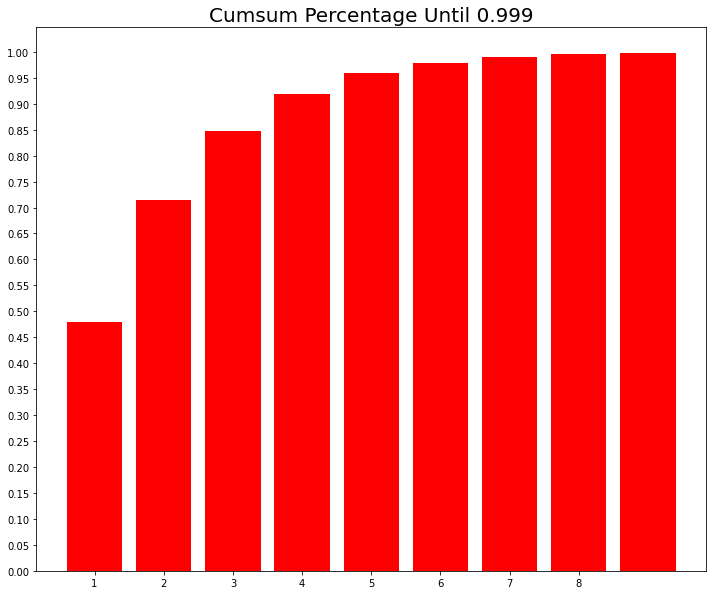

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(np.arange(length_percent_cumsum_999.index.all(), length_percent_cumsum_999.index.max(), 1))
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [15]:
dt.datetime.utcfromtimestamp(data['Time'].min()).strftime('%Y-%m-%d')

'2000-04-25'

In [16]:
dt.datetime.utcfromtimestamp(data['Time'].max()).strftime('%Y-%m-%d')

'2003-02-28'

In [17]:
data['Time'].max()

1046454590

In [19]:
data = data[data['Rating']>=3]
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


In [47]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - (86400 * n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - (86400 * n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [48]:
tr, test = split_by_date(data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

In [49]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [50]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 833744
	 Sessions: 421424
	 Items: 3627
	 First Time : 956703932
	 Last Time : 1041267244

* valid Set Stats Info
	 Events: 1495
	 Sessions: 1063
	 Items: 975
	 First Time : 1041272462
	 Last Time : 1043859613

* test Set Stats Info
	 Events: 1238
	 Sessions: 920
	 Items: 845
	 First Time : 1043869051
	 Last Time : 1046454590



In [51]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [52]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [53]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [54]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,978300019,0,0
1,1,1270,5,978300055,1,1
2,1,1721,4,978300055,1,2
3,1,1022,5,978300055,1,3
4,1,2340,3,978300103,2,4
5,1,1836,5,978300172,3,5
6,1,3408,4,978300275,4,6
7,1,2804,5,978300719,5,7
8,1,1207,4,978300719,5,8
9,1,1193,5,978300760,6,9


In [55]:
tr_dataset.click_offsets

array([     0,      1,      4, ..., 833742, 833743, 833744], dtype=int32)

In [56]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 421421, 421422, 421423])

In [57]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [58]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,978300019,0,0
1,1,1270,5,978300055,1,1
2,1,1721,4,978300055,1,2
3,1,1022,5,978300055,1,3
4,1,2340,3,978300103,2,4
5,1,1836,5,978300172,3,5
6,1,3408,4,978300275,4,6
7,1,2804,5,978300719,5,7
8,1,1207,4,978300719,5,8
9,1,1193,5,978300760,6,9


In [59]:
iter_ex = iter(tr_data_loader)

In [60]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [19  1  7  9]
Label Item Idx are :       [20  2  8 10]
Previous Masked Input Idx are [0]


In [61]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [62]:
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [63]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [68]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [69]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3627)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    551850    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3627)               184977    
Total params: 736,827
Trainable params: 736,827
Non-trainable params: 0
_________________________________________________________________


In [70]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [71]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)

Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.09it/s]


	 - Recall@20 epoch 1: 0.136719
	 - MRR@20    epoch 1: 0.058033



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.50it/s]


	 - Recall@20 epoch 2: 0.207031
	 - MRR@20    epoch 2: 0.088697



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.56it/s]


	 - Recall@20 epoch 3: 0.246094
	 - MRR@20    epoch 3: 0.088297



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.67it/s]


	 - Recall@20 epoch 4: 0.257812
	 - MRR@20    epoch 4: 0.098057



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.58it/s]


	 - Recall@20 epoch 5: 0.261719
	 - MRR@20    epoch 5: 0.100929



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.59it/s]


	 - Recall@20 epoch 6: 0.269531
	 - MRR@20    epoch 6: 0.106483



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.70it/s]


	 - Recall@20 epoch 7: 0.281250
	 - MRR@20    epoch 7: 0.104695



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.62it/s]


	 - Recall@20 epoch 8: 0.281250
	 - MRR@20    epoch 8: 0.103052



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.71it/s]


	 - Recall@20 epoch 9: 0.281250
	 - MRR@20    epoch 9: 0.103731



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.66it/s]

	 - Recall@20 epoch 10: 0.285156
	 - MRR@20    epoch 10: 0.103175



In [72]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

	 - Recall@20: 0.269531
	 - MRR@20: 0.099820



In [73]:
args2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.0001, epochs=20, k=20)
model2 = create_model(args2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3627)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    551850    
_________________________________________________________________
dropout_2 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 3627)               184977    
Total params: 736,827
Trainable params: 736,827
Non-trainable params: 0
_________________________________________________________________


In [74]:
train_model(model2, args2)

Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.21it/s]


	 - Recall@20 epoch 1: 0.058594
	 - MRR@20    epoch 1: 0.014261



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]


	 - Recall@20 epoch 2: 0.058594
	 - MRR@20    epoch 2: 0.014253



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]


	 - Recall@20 epoch 3: 0.058594
	 - MRR@20    epoch 3: 0.014257



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.38it/s]


	 - Recall@20 epoch 4: 0.062500
	 - MRR@20    epoch 4: 0.014625



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.35it/s]


	 - Recall@20 epoch 5: 0.066406
	 - MRR@20    epoch 5: 0.014857



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.41it/s]


	 - Recall@20 epoch 6: 0.062500
	 - MRR@20    epoch 6: 0.016743



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.36it/s]


	 - Recall@20 epoch 7: 0.062500
	 - MRR@20    epoch 7: 0.023119



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.32it/s]


	 - Recall@20 epoch 8: 0.074219
	 - MRR@20    epoch 8: 0.026775



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]


	 - Recall@20 epoch 9: 0.082031
	 - MRR@20    epoch 9: 0.027796



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.44it/s]


	 - Recall@20 epoch 10: 0.085938
	 - MRR@20    epoch 10: 0.029235



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.50it/s]


	 - Recall@20 epoch 11: 0.089844
	 - MRR@20    epoch 11: 0.033245



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.42it/s]


	 - Recall@20 epoch 12: 0.105469
	 - MRR@20    epoch 12: 0.039307



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.51it/s]


	 - Recall@20 epoch 13: 0.117188
	 - MRR@20    epoch 13: 0.044420



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.51it/s]


	 - Recall@20 epoch 14: 0.113281
	 - MRR@20    epoch 14: 0.053386



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.51it/s]


	 - Recall@20 epoch 15: 0.117188
	 - MRR@20    epoch 15: 0.059953



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.53it/s]


	 - Recall@20 epoch 16: 0.121094
	 - MRR@20    epoch 16: 0.061963



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.50it/s]


	 - Recall@20 epoch 17: 0.144531
	 - MRR@20    epoch 17: 0.064309



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.50it/s]


	 - Recall@20 epoch 18: 0.156250
	 - MRR@20    epoch 18: 0.065771



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]


	 - Recall@20 epoch 19: 0.160156
	 - MRR@20    epoch 19: 0.068800



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.58it/s]

	 - Recall@20 epoch 20: 0.171875
	 - MRR@20    epoch 20: 0.069344



In [75]:
test_model(model2, args2, test)

Evaluation: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

	 - Recall@20: 0.207031
	 - MRR@20: 0.070961



In [79]:
args3 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.0005, epochs=15, k=20)
model3 = create_model(args3)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(64, 1, 3627)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      551850    
_________________________________________________________________
dropout_4 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_4 (Dense)              (64, 3627)                184977    
Total params: 736,827
Trainable params: 736,827
Non-trainable params: 0
_________________________________________________________________


In [80]:
train_model(model3, args3)

Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


	 - Recall@20 epoch 1: 0.111979
	 - MRR@20    epoch 1: 0.031624



Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


	 - Recall@20 epoch 2: 0.158854
	 - MRR@20    epoch 2: 0.061014



Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]


	 - Recall@20 epoch 3: 0.213542
	 - MRR@20    epoch 3: 0.077632



Evaluation: 100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


	 - Recall@20 epoch 4: 0.242188
	 - MRR@20    epoch 4: 0.091501



Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


	 - Recall@20 epoch 5: 0.273438
	 - MRR@20    epoch 5: 0.094705



Evaluation: 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


	 - Recall@20 epoch 6: 0.281250
	 - MRR@20    epoch 6: 0.098964



Evaluation: 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


	 - Recall@20 epoch 7: 0.283854
	 - MRR@20    epoch 7: 0.095903



Evaluation: 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


	 - Recall@20 epoch 8: 0.289062
	 - MRR@20    epoch 8: 0.098338



Evaluation: 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


	 - Recall@20 epoch 9: 0.286458
	 - MRR@20    epoch 9: 0.096952



Evaluation: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


	 - Recall@20 epoch 10: 0.296875
	 - MRR@20    epoch 10: 0.100025



Evaluation: 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


	 - Recall@20 epoch 11: 0.296875
	 - MRR@20    epoch 11: 0.103061



Evaluation: 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


	 - Recall@20 epoch 12: 0.299479
	 - MRR@20    epoch 12: 0.103422



Evaluation: 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


	 - Recall@20 epoch 13: 0.309896
	 - MRR@20    epoch 13: 0.107447



Evaluation: 100%|██████████| 6/6 [00:01<00:00,  3.00it/s]


	 - Recall@20 epoch 14: 0.309896
	 - MRR@20    epoch 14: 0.107196



Evaluation: 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]

	 - Recall@20 epoch 15: 0.309896
	 - MRR@20    epoch 15: 0.105720



In [81]:
test_model(model3, args3, test)

Evaluation: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

	 - Recall@20: 0.234375
	 - MRR@20: 0.092606



# 회고

## data preprocessing? data analysing?

데이터 전처리를 하는 과정에서 많이 애먹었다. 처음에는 아주 단순하게 'userid 자체를 sessionid로 생각하고 정의하면 되지 않을까?'라고 생각했는데 전혀 아니었다. user와 time과의 관계도 고려하고 싶었고 같은 user가 다른 item에 대한 평가를 한 부분도 고려하고 싶었다. user와 time을 그룹으로 sessionid를 새로 정의한다는 생각 자체를 못했다. 한참을 헤매이다가 결국 이름모를 어느 고수분의 코드를 많이 참조했다. 물론 모델을 빌드하는 과정도 내가 알지 못하는 많은 요소를 첨가할 수록 한없이 어려워지겠지만 데이터분석이나 전처리 부분은 사실 명확하게 참조할 자료를 정의하기가 어려워 힘든 것 같다. 가령 모델을 빌드할 경우 쓰이는 패키지안에서 class나 method를 잘 살펴본다던지, 구축하고자 하는 모델의 이름(ex. RNN, BERT etc)으로 서칭하면 나름 방향 정도는 잡을 수 있었는데, 데이터전처리나 시각화의 경우 사용되는 패키지는 더 한정적인 것 같지만 그 활용이 너무나도 무궁무진하고 데이터에 따라 천차만별이여서 아무리 서칭을 해도 감조차 잡을 수 없는 경우가 많다. 아주 유명하게 많이 다뤄진 데이터(ex. iris etc)가 아니라면 더더욱 그렇다.

## class와 method

사실 여지껏 노드를 하면서 대표적인 두 가지 다른 성격의 코드를 분류할 수 있게 되었는데, 바로 'class를 많이 활용하느냐 그렇지 않느냐'였다. 어떤 노드의 제작자분은 가능한 반복되는 기능일지라도 class로 선언하지 않으면서(아마 코드 자체의 기능을 면밀히 살펴보게끔 해주시는 배려였을지도) 진행하시는 반면, 어떤 분의 노드는 기능 별로 class를 모두 선언하여 한꺼번에 사용하시는 형태를 띄었다. 처음에는 class안에 내용 자체를 해석하기도 너무 힘들고 계단식으로 진행되지 않으면 자꾸 돌아가서 다시 보게되고 이해에 혼선이 많이 빚어져서 싫었는데, 이번 노드를 통해 확실히 편리한 방법이라는 생각이 든다. 전체 코드를 긁어와서 모든 할당되는 변수를 점검해서 바꿔주고 중복을 방지하기 위해 실제 필요한 코드보다 더 많은 양을(데이터 원본을 다시 로드한다던지) 긁어서 돌려야하는 등의 절차가 상당히 간소화된다. 물론 문제가 발생되지 않도록 class를 정확하게 설계하는 것은 어려울 것이다. 해본 적도 없을 뿐더러 할 자신도 없다. 그래도 자꾸 배우다보면 언젠가 저렇게 사용하고 있지 않을까.

# Ref.

* e16 code<br><br>
https://github.com/kec0130/AIFFEL-project/blob/main/exploration/E17_session_based_rec_pjt.ipynb
---------------------------
* datetime package<br><br>
https://datascienceschool.net/01%20python/02.15%20%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%97%90%EC%84%9C%20%EB%82%A0%EC%A7%9C%EC%99%80%20%EC%8B%9C%EA%B0%84%20%EB%8B%A4%EB%A3%A8%EA%B8%B0.html<br><br>
https://python.bakyeono.net/chapter-11-3.html
